### Model Assumptions
- Multiple candidate stops (neighborhoods) per zip code (zone)
- Pick only one of the multiple stops per zone
- One bus
- One school
- Start and end at school
- Each stop must be visited once
- Accounting for both aggregate last mile walked time and aggregate bus travel time
- Not accounting for operational costs because only one bus 
- Infinite capacity on bus

In [1]:
from gurobipy import *
import numpy as np
import pandas as pd

### Data

In [2]:
minadeo = pd.read_csv('minadeo_stops_all.csv')
total_students = minadeo.groupby('ZONE_AREA')['NUM_KIDS'].agg(sum).reset_index()
total_students.columns = ['ZONE_AREA', 'ZONE_POP']

data = pd.merge(minadeo, pd.DataFrame(total_students, columns = ['ZONE_AREA', 'ZONE_POP']).reset_index(), on = "ZONE_AREA")

data = data.sort_values('STOP_ID')

In [3]:
# Population in zones
pop = list(data.ZONE_POP.unique())

pop

[0, 84, 48, 69, 11, 38]

In [4]:
# Binary matrix telling what hoods are in what zones

zones = list(data.ZONE_AREA.unique())
zones_hoods = []

for s in list(data.ZONE_AREA):
    zones_hoods.append([1 if s == z else 0 for z in zones])
    
zones_hoods

[[1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0]]

In [5]:
# Total aggergate walking distances from stops to their zones
walking_dist = list(data.TWT)
walking_dist

[0.0,
 750.2722183,
 139.6017573,
 313.23512289999996,
 491.01301219999993,
 242.1504607,
 229.3882437,
 21.21991845,
 96.88094944,
 181.04991730000003,
 18.72160063]

In [6]:
# travel times

tt = pd.read_csv('distance_matrix.csv')

tt.Distance = (tt.Distance/1609.344)*(60.0/30.0) # convert from meters to minutes

def get_distance(i,j):
    if i==j:
        return(0)
    else:
        try:
            d = tt.loc[(tt.InputID==i)&(tt.TargetID==j),'Distance'].iloc[0]
            return(d)
        except:
            print('No distance found for i={},j={}'.format(i,j))

In [7]:
# Initial number of kids
initial_kids = sum(pop)

# Total number of segments
max_segments = len(pop)

### Indeces

In [8]:
stops = range(data.shape[0])
segments = range(max_segments)
zones = range(len(pop))

### Setting up Model

In [9]:
m = Model("Last Mile Model 2 Final")

Using license file /Users/matty_sam/gurobi.lic
Academic license - for non-commercial use only


### Decision Variables

In [10]:
# Binary variable for whether to go from stop i to j at segment s
y = m.addVars(stops, stops, segments, 
              lb = 0.0, vtype = GRB.BINARY)

# Binary variable for whether stop is selected or not
x = m.addVars(stops, lb = 0.0, vtype = GRB.BINARY)

# Auxiliary variable for how many students are on bus at a segment
b = m.addVars(segments, lb = 0.0, vtype = GRB.INTEGER)

### Objective Function

In [11]:
# The objective is to minimize total time students spend on the bus and walking time

obj = LinExpr()

bus_travel = 0

for i in stops:
    for j in stops:
        for s in segments:
            bus_travel += b[s] * get_distance(i,j) * y[i,j,s]
            
walking_travel = 0

for i in stops:
    for k in zones:
        walking_travel +=  x[i] * walking_dist[i] * zones_hoods[i][k] 

obj = bus_travel + walking_travel
            
m.setObjective(obj, GRB.MINIMIZE)

### Constraints

In [12]:
# Kids on bus continuity constraint
for s in segments:
    m.addConstr(b[s] == initial_kids -
               sum(sum(sum(sum(y[i,j,z] * pop[k] * zones_hoods[j][k] for z in range(s))
                                                                 for j in stops)
                                                                 for i in stops)
                                                                 for k in zones))
# Continuous route
for a in stops:
    for s in range(0, max(segments)):
        m.addConstr((sum(y[a,j,s+1] for j in stops) - 
                     sum(y[i,a,s] for i in stops)) == 0)

# # Start at school constraint
m.addConstr(sum(y[0,j,0] for j in stops) == 1)

# Make sure school is selected
m.addConstr(x[0] == 1)
                
# Every stop is visited once constraint
for j in stops:
    m.addConstr(sum(sum(y[i,j,s] for s in segments)
                                 for i in stops) == x[j])
    
# # Every stop is left once constraint
for i in stops:
    m.addConstr(sum(sum(y[i,j,s] for s in segments)
                                 for j in stops) == x[i])
    
# Cannot have same origin and destination constraint
for i in stops:
    for s in segments:
        m.addConstr(y[i,i,s] == 0)

# Each zone is visited exactly once
for k in zones:
    m.addConstr(sum(x[i] * zones_hoods[i][k] for i in stops) == 1)

### Solve

In [13]:
m.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 157 rows, 743 columns and 4429 nonzeros
Model fingerprint: 0xa12cf78d
Model has 660 quadratic objective terms
Variable types: 0 continuous, 743 integer (737 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [2e+01, 8e+02]
  QObjective range [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 79 rows and 232 columns
Presolve time: 0.06s
Presolved: 488 rows, 921 columns, 4112 nonzeros
Variable types: 0 continuous, 921 integer (505 binary)
Found heuristic solution: objective 3568.1295971
Found heuristic solution: objective 2977.0163891

Root relaxation: objective 1.079577e+03, 77 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1079.57657    0   22 2977.01639 1079.57657  63.7%     -    0s
H   

In [14]:
obj.getValue()

2082.9645311160566

In [15]:
kids_on_bus = list()

for s in segments:
    for i in stops:
        for j in stops:
            if y[i,j,s].x == 1:
                print("kids on bus: ", b[s].x)
                kids_on_bus.append(b[s].x)

kids on bus:  250.0
kids on bus:  181.0
kids on bus:  97.0
kids on bus:  49.0
kids on bus:  11.0
kids on bus:  0.0


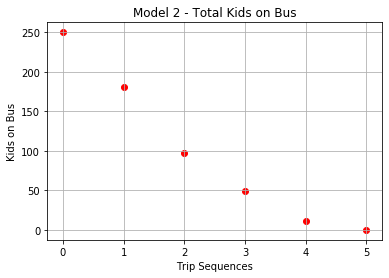

In [22]:
# Graphing outcomes
import matplotlib.pyplot as plt

plt.scatter(range(len(kids_on_bus)), kids_on_bus, color = 'r')
plt.xlabel('Trip Sequences')
plt.ylabel('Kids on Bus')
plt.title('Model 2 - Total Kids on Bus')
plt.grid()
plt.show()

In [17]:
walking_travel.getValue()

1059.4524424699998

In [18]:
bus_travel.getValue()

1023.5120886460569

In [19]:
for s in segments:
    for i in stops:
        for j in stops:
            if y[i,j,s].x == 1:
                print("segment ", s, ": ", i, " -> ", j)

segment  0 :  0  ->  4
segment  1 :  4  ->  3
segment  2 :  3  ->  2
segment  3 :  2  ->  8
segment  4 :  8  ->  10
segment  5 :  10  ->  0


# Goal programming

In [20]:
bus_outcomes = list()
walking_outcomes = list()
alpha_list = list(np.arange(0,1.1, step=0.1))

for alpha in alpha_list:
    m = Model("Last Mile Model 2 Final")
    
    # Binary variable for whether to go from stop i to j at segment s
    y = m.addVars(stops, stops, segments, 
                  lb = 0.0, vtype = GRB.BINARY)

    # Binary variable for whether stop is selected or not
    x = m.addVars(stops, lb = 0.0, vtype = GRB.BINARY)

    # Auxiliary variable for how many students are on bus at a segment
    b = m.addVars(segments, lb = 0.0, vtype = GRB.INTEGER)
    
    # The objective is to minimize total time students spend on the bus and walking time

    obj = LinExpr()

    bus_travel = 0

    for i in stops:
        for j in stops:
            for s in segments:
                bus_travel += b[s] * get_distance(i,j) * y[i,j,s]

    walking_travel = 0

    for i in stops:
        for k in zones:
            walking_travel +=   x[i] * walking_dist[i] * zones_hoods[i][k]

    obj = (alpha * bus_travel) + ((1- alpha) * walking_travel)

    m.setObjective(obj, GRB.MINIMIZE)
    
    # Kids on bus continuity constraint
    for s in segments:
        m.addConstr(b[s] == initial_kids -
                   sum(sum(sum(sum(y[i,j,z] * pop[k] * zones_hoods[j][k] for z in range(s))
                                                                     for j in stops)
                                                                     for i in stops)
                                                                     for k in zones))
    # Continuous route
    for a in stops:
        for s in range(0, max(segments)):
            m.addConstr((sum(y[a,j,s+1] for j in stops) - 
                         sum(y[i,a,s] for i in stops)) == 0)

    # # Start at school constraint
    m.addConstr(sum(y[0,j,0] for j in stops) == 1)

    # Make sure school is selected
    m.addConstr(x[0] == 1)

    # Every stop is visited once constraint
    for j in stops:
        m.addConstr(sum(sum(y[i,j,s] for s in segments)
                                     for i in stops) == x[j])

    # # Every stop is left once constraint
    for i in stops:
        m.addConstr(sum(sum(y[i,j,s] for s in segments)
                                     for j in stops) == x[i])

    # Cannot have same origin and destination constraint
    for i in stops:
        for s in segments:
            m.addConstr(y[i,i,s] == 0)

    # Each zone is visited exactly once
    for k in zones:
        m.addConstr(sum(x[i] * zones_hoods[i][k] for i in stops) == 1)
        
    m.optimize()
    
    bus_outcomes.append(bus_travel.getValue())
    walking_outcomes.append(walking_travel.getValue())

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 157 rows, 743 columns and 4429 nonzeros
Model fingerprint: 0x67b47c70
Variable types: 0 continuous, 743 integer (737 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [2e+01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 84 rows and 238 columns
Presolve time: 0.06s
Presolved: 73 rows, 505 columns, 2184 nonzeros
Variable types: 0 continuous, 505 integer (505 binary)
Found heuristic solution: objective 797.8276740

Explored 0 nodes (0 simplex iterations) in 0.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 797.828 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.978276739700e+02, best bound 7.978276739700e+02, gap 0.0000%
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 157 rows, 743 columns and 4429 nonzeros
Model fingerprint: 0x5dc09144
Model has 660 quadratic 

     0     0  670.84801    0   13  998.88855  670.84801  32.8%     -    0s
     0     0  671.68218    0   14  998.88855  671.68218  32.8%     -    0s
     0     0  703.74367    0   40  998.88855  703.74367  29.5%     -    0s
     0     0  739.21573    0   39  998.88855  739.21573  26.0%     -    0s
     0     0  797.41867    0   35  998.88855  797.41867  20.2%     -    0s
     0     0  798.91766    0   34  998.88855  798.91766  20.0%     -    0s
     0     0  798.91766    0   34  998.88855  798.91766  20.0%     -    0s
     0     0  798.91766    0   44  998.88855  798.91766  20.0%     -    0s
     0     0  808.65875    0   45  998.88855  808.65875  19.0%     -    0s
H    0     0                     996.6982657  945.84874  5.10%     -    0s
     0     0  996.69827    0   36  996.69827  996.69827  0.00%     -    0s

Cutting planes:
  Gomory: 5
  Implied bound: 24
  Clique: 4
  MIR: 10
  Zero half: 2
  RLT: 8
  BQP: 1

Explored 1 nodes (659 simplex iterations) in 0.68 seconds
Thread count

H    0     0                    1149.6842089  479.83483  58.3%     -    0s
     0     0  645.81510    0   14 1149.68421  645.81510  43.8%     -    0s
     0     0  659.78526    0   14 1149.68421  659.78526  42.6%     -    0s
H    0     0                    1107.1731840  690.12708  37.7%     -    0s
     0     0  701.02590    0   38 1107.17318  701.02590  36.7%     -    0s
     0     0  703.09648    0   34 1107.17318  703.09648  36.5%     -    0s
     0     0  703.09648    0   40 1107.17318  703.09648  36.5%     -    0s
H    0     0                    1104.7696575  703.09648  36.4%     -    0s
     0     0  703.09648    0   30 1104.76966  703.09648  36.4%     -    0s
     0     0  703.09648    0   42 1104.76966  703.09648  36.4%     -    0s
     0     0  703.09648    0   44 1104.76966  703.09648  36.4%     -    0s
     0     0  828.30417    0   41 1104.76966  828.30417  25.0%     -    0s
H    0     0                    1034.2941948  828.30417  19.9%     -    0s
     0     0  892.86645  

H    0     0                    1082.6047784  331.10341  69.4%     -    0s
H    0     0                    1080.2418767  331.10341  69.3%     -    0s
     0     0  491.93312    0   18 1080.24188  491.93312  54.5%     -    0s
     0     0  494.08568    0   16 1080.24188  494.08568  54.3%     -    0s
     0     0  559.92666    0   25 1080.24188  559.92666  48.2%     -    0s
     0     0  570.93256    0   17 1080.24188  570.93256  47.1%     -    0s
     0     0  570.93256    0   35 1080.24188  570.93256  47.1%     -    0s
H    0     0                    1006.8518426  570.93256  43.3%     -    0s
H    0     0                    1005.7949248  570.93256  43.2%     -    0s
     0     0  570.93256    0   36 1005.79492  570.93256  43.2%     -    0s
H    0     0                     973.6900336  843.17406  13.4%     -    0s
H    0     0                     971.3271320  843.17406  13.2%     -    0s
     0     0  971.32713    0   45  971.32713  971.32713  0.00%     -    0s

Cutting planes:
  Gomory

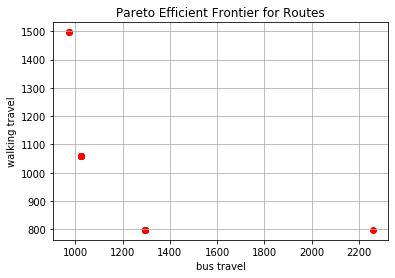

In [21]:
# Graphing outcomes
import matplotlib.pyplot as plt

plt.scatter(bus_outcomes, walking_outcomes, color = 'r')
plt.xlabel('bus travel')
plt.ylabel('walking travel')
plt.title('Pareto Efficient Frontier for Routes')
plt.grid()
plt.show()